<a href="https://colab.research.google.com/github/RahmanKhorramfar91/UAI_AI_Energy_Case_Studies/blob/main/Case%20Study%202%20-%20Extreme%20Events_Identification%20and%20Generation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case Study 2 - Universal AI, AI and Sustainability: Energy**




This case study is prepared by [Rahman Khorramfar](https://www.rahmankhorramfar.com/) for the ***AI and Sustainability: Energy*** module instructed by Professor [Saurabh Amin](https://cee.mit.edu/people_individual/saurabh-amin/). The module is part of the Universal AI course.

My email for questions, suggestions, and comments: khorram@mit.edu

## About the Case Study

AI-driven extreme scenario (e.g., day) generation bolsters the grid resiliency by hedging the downstream planning task against unforeseen weather events that could stress the system. Here, we supplement Lecture 2 by providing basic implementations for some of the well-known outlier detection and generative methods in the context of energy planning and optimization.

The goal of the case study is **two-fold**: i) **identify** extreme days; ii) **generate** extreme days. For the first task, we will use three methods, including DBSCAN, GMM, and VAE. Each method can identify a different set of extreme days. Therefore, in practice, we treat these results as *suggestions* and conduct further analysis to determine whether these sets are actually extreme days. This latter part is problem-dependent and not covered here. For example, extreme days for a utility company can be those that stress the distribution grid, whereas a company that owns and operates power generators may classify a day as extreme if its load exceeds a certain level *before* scheduled maintenance of generators.

The scenario generation part covers variational autoencoder (VAE) and its conditional and more versatile version, conditional VAE (CVAE). The generative methods implemented here are illustrative and may not necessarily result in realistic scenarios. In practice, a high-fidelity scenario generation requires more complex models with tailored architecture, hyperparameter tuning, richer datasets, and domain knowledge.

The case study concludes with questions for the learners. The first question requires extreme day identification based on historical load data from Texas. The second question requires extreme scenario generation conditioned on the total daily load. The combination of these two tasks can provide a basis for



**Overview of the content**:

1. [Definitions and Basic Concepts](#definitions)
2. [Getting Started](#getting_started)
3. [DBSCAN](#DBSCAN)
4. [Gaussian Mixture Model (GMM)](#GMM)
5. [Autoencoder](#AE)
6. [Variational Autoencoder](#VAE)
7. [Conditional Variational Autoencoder](#CVAE)
8. [Case Study Questions](#questions)
9. [References and Further Reading](#references)

<br>
<br>
<br>

# **<font color='blue'>1. Definitions and Basic Concepts </font>** [<a name="definitions"></a>](https://)

## Definitions
- **Extreme events**: A rare, high-impact occurrence that challenges system reliability, often caused by extreme weather, equipment failure, and cyber-physical attacks.

- **Anomalous data**: Data points that are significantly different from the rest, often caused by equipment failure, sensor faults, load spikes, renewable dips, and cyber threats.

- **Outlier data**: Abnormal data points that deviate from the expected trend, often caused by heat domes, wind droughts and other extreme events.

- **Stress situation**: Periods at which the system operates at its technical and economic limits, often caused by extreme events.

- **Extreme day**: A day with unusually high or low demand/supply that causes stress situations, often driven by extreme weather events. Extreme days are important for resource adequacy (meeting all demand), peak capacity planning, and electricity pricing.




# **<font color='blue'>2. Getting Started </font>**  <a name="getting_started"></a>

Similar to Case Study 1, we will work with the historical data for the US New England region.  The data is available at the [ISO New England (ISONE) website](https://www.iso-ne.com/system-planning/planning-models-and-data/variable-energy-resource-data/) under *2024_isone_variable_energy_resource_ver_data_series_2000-2023_rev1*. The dataset contains hourly time series data for load, wind, and solar between 2000 and 2023 (24 years) for 8 New England zones, as well as the region. Here, we selected the aggregated load time series for ISONE and curated the data slightly for better readability. The curated data is available at [the GitHub repository](https://github.com/RahmanKhorramfar91/UAI_AI_Energy_Case_Studies), created to store data and codes for all the case studies.



In [ ]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
from sklearn.cluster import DBSCAN;
from sklearn.mixture import GaussianMixture;
from sklearn.metrics import silhouette_score;
import zipfile;
import time, os;
import tensorflow as tf;
from tensorflow.keras.layers import *;
from tensorflow.keras.models import Model;
from tensorflow.keras.utils import plot_model;
from tensorflow.keras.losses import mse, binary_crossentropy;
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler;
from tensorflow.keras.layers import Lambda;
from tensorflow.keras import backend as K;
from tensorflow.keras import callbacks;

# Load and Prepare the Data

In [ ]:
!git clone 'https://github.com/RahmanKhorramfar91/UAI_AI_Energy_Case_Studies.git';
zip_file_path = os.getcwd()+'/UAI_AI_Energy_Case_Studies/load_time_series_data_ISONE_2000-2023.zip';
extract_dir = os.getcwd()+'/load_time_series_data_ISONE_2000-2023';
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir);

## Data Preview and Preprocessing
Read the data for a particular year and add some temporal features (week of the year, day of week, etc.) to the dataset.

In [ ]:
yr = 2023;
zone = 'ISONE';
data = pd.read_csv(f'/content/load_time_series_data_ISONE_2000-2023/load_time_series_data/{yr}_{zone}_load.csv');
data.head(4)

In [ ]:
# add basic temporal features
data['hour_of_year'] = data.index+1;
data.index = pd.to_datetime(data.date);
data['date'] = data.index;
data['day_of_week'] = data['date'].dt.dayofweek;
data['day_of_year'] = data['date'].dt.dayofyear;
# data['week_of_year'] = data['date'].dt.dayofyear//7 + 1;

In [ ]:
# a dataframe to daily info as well as the results of outlier detection algorithms
selected_columns = ['gross_load_MW' ,'temperature_C','global_horizontal_irradiance', '10m_wind_speed', 'day_of_year','day_of_week'];
data_selected = data[selected_columns];
daily_agg = data_selected.groupby('day_of_year').agg({
    'gross_load_MW': 'sum',
    'temperature_C': 'mean',
    'global_horizontal_irradiance': 'mean',
    '10m_wind_speed': 'mean',
    'day_of_week': 'mean'
    });
daily_agg.reset_index(inplace=True);

Since our goal is to identiy extreme days, we create a dataset whose rows represent each day, and columns indicate hourly features. Therefore, every 24 rows of $C$ columns is flattened into a one row of $24\times C$ columns. We then standardize the data for numerical consistency.


In [ ]:
selected_columns = ['gross_load_MW', 'temperature_C', 'global_horizontal_irradiance', '10m_wind_speed'];
data_selected = data[selected_columns];
hourly_data = data_selected.to_numpy();

# reshape the hourly data into daily batches. Notice that the reshaped data has the form load1, temp1, irradiance1, load 2, temp2, ...
daily_hourly_3D = hourly_data.reshape(-1,24, hourly_data.shape[1]);
daily_hourly_flattened = daily_hourly_3D.reshape(daily_hourly_3D.shape[0], -1);
# flatten the array for each day and standardize the data. Keep mean and std of each column (feature) for later use.
scaler = StandardScaler();
daily_hourly_standardized =  scaler.fit_transform(daily_hourly_3D.reshape(daily_hourly_3D.shape[0], -1));
daily_hourly_standardized = np.nan_to_num(daily_hourly_standardized, nan=0.01); # IMPORTANT: replace 'nan' with a small number to avoid numerical instabilities late

cols_mean = scaler.mean_;
cols_std = scaler.scale_;
print(daily_hourly_standardized.shape);
print(cols_mean.shape);
print(daily_hourly_flattened[0,:2*len(selected_columns)]);

# **<font color='red'>Part one: Extreme Days Identification </font>** <a name="baseline"></a>

# **<font color='blue'>3. DBSCAN </font>** <a name="DBSCAN"></a>

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is one of the most intuitive clustering methods for energy applications. Given two parameters $\epsilon$ (epsilon) and `minPts`, the steps of the algorithms in simple terms are as follows:

- For each data point, find all its neighbors within the radius of $\epsilon$
- Identify a **core points** with at least `minPts` neighbors
- Expand the clusters by including all *reachable neighbors*, which are points that are directly reachable as they are located within $\epsilon$ distance from the core point, or are indirectly reachable through a chain of direct neighbors.
- Identify **outliers** as points that are not reachable from any other point.

As evident by the process, DBSCAN **does not require the number of clusters** like in k-means. DBSCAN and its variants are known to show higher scalability; however, they can be sensitive to parameter choice and present poor performance in high-dimensional data.

The rules of thumb for `minPtn` are from 5 to $2\times$dimension* (here, between 5 and 48). The value of $\epsilon$ can be determined using the *K-distance elbow plot* method, in which the distance of each point from its k-th nearest neighbor is calculated, plotted in ascending order, and the sharp bend (elbow) point is identified.  






In [ ]:
# apply DBSCAN
dbscan_model = DBSCAN(eps=8, min_samples=40).fit(daily_hourly_standardized);
daily_agg['cluster_DBSCAN'] = dbscan_model.labels_;
print(daily_agg['cluster_DBSCAN'].value_counts());
# daily_agg.head(3)

In DBSCAN, each point is assigned to a cluster specified by a number, starting from 0 (cluster 0, cluster 1, etc.). The noise points (outliers) are assigned value -1, indicating that they are not reachable from other points.

Next, we evaluate the performance of the algorithm using the *silhouette score* that indicates the fitness of each point to its assigned cluster. The score ranged from -1 to 1, and the higher the score (>0.6), the better the clustering.



In [ ]:
# get the silhouette score
silhouette_score(daily_hourly_standardized, dbscan_model.labels_)

Plot the outliers on different x-axis to highlight their position per each attribute (week, temperature, day of year).

In [ ]:
# plot the outliers
# plot the raw daily data for load and irradiance
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4),
                       gridspec_kw={'width_ratios': [10, 10, 10],'height_ratios': [5],
                       'wspace': 0.1,'hspace': 0.1});
columns_to_plot = ['day_of_week', 'temperature_C', 'day_of_year'];
outlier_week_day = daily_agg['day_of_week'][daily_agg['cluster_DBSCAN']==-1];

for i in range(len(columns_to_plot)):
  ax[i].scatter(daily_agg[columns_to_plot[i]], daily_agg['gross_load_MW'], color='blue', s=20);
  ax[i].scatter(daily_agg[columns_to_plot[i]][outlier_week_day.index], daily_agg['gross_load_MW'].iloc[outlier_week_day.index],
                color='red', s=100, facecolors='none', edgecolors='red', label='DBSCAN Outlier');
  if i>0:ax[i].set_yticklabels([]);

  ax[i].set_title('vs '+ columns_to_plot[i]);

<br>
<br>
<br>

# **<font color='blue'>4. Gaussian Mixture Model (GMM) </font>** <a name="GMM"></a>

GMM is a probabilistic model that represents a time series by a weighted sum of multiple Gaussian (normal) distributions. In other words, each datapoint is assumed to be generated from a mixture of several Gaussian distributions, each with different statistical properties. Therefore, unlike K-means, GMM has a *soft assignment* for each data point, making it a powerful tool for clustering tasks, as it is often difficult to fully assign a point to a single cluster.

## How to Determine the Number of Clusters

Unlike DBSCAN, the GMM method requires the number of clusters to be specified by the user, who can determine the cluster number by the following common methods:

- **Domain knowledge** in which practical insights can help determine the value. For example, an energy expert may divide days into weekdays, weekends, and holidays, or into 4 clusters of normal, hot, cold, and abnormal (too hot or too cold).

- **AIC** (Akaike Information Criterion) and **BIC** (Bayesian Information Criterion) plots that indicate goodness-of-fit and penalize too much granulation to prevent overfitting. The plot elbow (significant dip) can determine the value. AIC prioritizes the model complexity, tending to suggest larger numbers; whereas BIC more strongly penalizes the complexity, leading to more conservative values.

- **Cross-validation** that splits the data into different training and test sets and chooses the value that results in the highest log-likelihood on the test data. This method is more robust but is computationally heavier.

- **Silhouette score** can be used in conjunction with the previous method.

Here, we use AIC and BIC plots. We use the domain knowledge to specify the range of cluster numbers.



In [ ]:
# Determine the optimal number of clusters for GMM using BIC
cluster_sizes = range(3, 15)
bic_scores = np.zeros(len(cluster_sizes));
aic_scores = np.zeros(len(cluster_sizes));

for ci, cv in enumerate(cluster_sizes):
    gmm = GaussianMixture(n_components=cv, random_state=50);
    gmm.fit(daily_hourly_standardized)
    bic_scores[ci] = gmm.bic(daily_hourly_standardized);
    aic_scores[ci] = gmm.aic(daily_hourly_standardized);

# Plot BIC scores to find the elbow (optimal number of clusters)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2),
                      gridspec_kw={'width_ratios': [10],'height_ratios': [5],
                      'wspace': 0.1,'hspace': 0.1});

ax.plot(cluster_sizes, bic_scores, 'r--', label = 'BIC Score');
ax.plot(cluster_sizes, aic_scores, 'bp', label = 'AIC Score');
ax.legend(loc='upper left', ncol=1);

The AIC/BIC plot is divergent, so no clear choice for the number of clusters. In these situations, one can try different values and domain intuition. In our context, we can start with lower cluster numbers and slightly increase the number of clusters to see the effect.

The outlier detection in GMM relies on *anomaly score* which measures how unlikely that a data point is to have been generated by the model. The anomaly score is the negative log-likelihood, and its high values indicate an outlier point.

In [ ]:
num_clusters = 2;

# Apply GMM with the selected number of clusters
gmm_model = GaussianMixture(n_components=num_clusters, random_state=42);
gmm_model.fit(daily_hourly_standardized);

# Predict the cluster for each data point
daily_agg['gmm_cluster'] = gmm_model.predict(daily_hourly_standardized);
probs = gmm_model.predict_proba(daily_hourly_standardized); # Probability of each data point beloinging to each cluster

# Get the anomaly score (based on log-likelihood) for each data point (lower values indicate a better fit)
anomaly_scores = gmm_model.score_samples(daily_hourly_standardized);
daily_agg['gmm_anomaly_score'] = anomaly_scores;

# Identify anomalys based on a threshold for anomaly scores. For example, 95th percentile.
threshold = 98; # %
threshold_score = np.percentile(daily_agg['gmm_anomaly_score'], threshold);
daily_agg['is_anomaly_gmm'] = daily_agg['gmm_anomaly_score'] > threshold_score;

print("\n GMM summary:");
print(daily_agg['is_anomaly_gmm'].value_counts());
print(daily_agg['gmm_anomaly_score'].min(), daily_agg['gmm_anomaly_score'].max());

Plot the outliers:

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4),
                       gridspec_kw={'width_ratios': [10, 10, 10],'height_ratios': [5],
                       'wspace': 0.1,'hspace': 0.1});
columns_to_plot = ['day_of_week', 'temperature_C', 'day_of_year'];
outliers_gmm = daily_agg[daily_agg['is_anomaly_gmm']]

for i in range(len(columns_to_plot)):
    scatter1 = ax[i].scatter(daily_agg[columns_to_plot[i]],
                             daily_agg['gross_load_MW'], c = daily_agg['gmm_cluster'], cmap='viridis');
    ax[i].scatter(outliers_gmm[columns_to_plot[i]],
                  outliers_gmm['gross_load_MW'], color='red',
                  s=100, facecolors='none', edgecolors='r', label='GMM Outlier');

    ax[i].set_yticklabels([]);
    if i==0:fig.colorbar(scatter1, ax=ax[2], label='GMM Cluster');
    ax[i].set_title('vs '+ columns_to_plot[i]);

<br>
<br>
<br>

# **<font color='blue'>5. Autoencoders </font>** <a name="AE"></a>

Autoencoder (AE) is a powerful neural network architecture to compress and reconstruct data. The two components of AE are: i) an **encoder** that takes input data and, over multiple layers, compresses it into a lower-dimensional representation known as *latent space or bottleneck*; ii) a **decoder** part that tries to reconstruct the original input from the latent representation. The AE is trained to minimize the difference between the original data, $x$, and its reconstruction $\hat{x}$. The bottleneck forces the network to discover the essential features within the data.




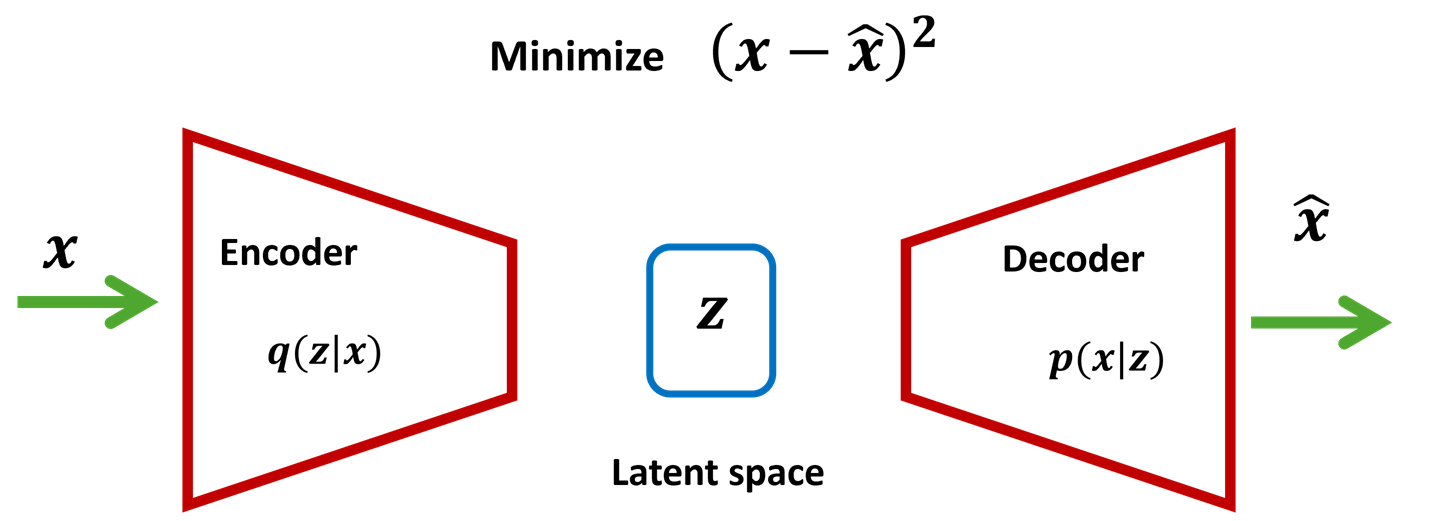

## AE for Extreme Day Detection

The best way to use AE for extreme day detection is to train the model on normal data, so that it learns the main patterns in typical days. The model can then be used on a new dataset and flag the days with high reconstruction error as extreme.

However, normal days are not always known, nor is there always enough data to train an AE. For our dataset that contains hourly values for a year, one way to identify extreme days is to train an AE for the entire year and flag the days with high reconstruction error as extreme.




In [ ]:
# Build encoder
INPUT_DIM = daily_hourly_standardized.shape[1]; # 24*len(exog_columns)
LATENT_DIM = 16 # Dimension of the latent space
EPOCH_NUM = 10;
BATCH_SIZE = 32;

filter_sizes = [16, 32];
ecoder_input = Input(shape=(INPUT_DIM, 1));
x = Conv1D(filters= filter_sizes[0], kernel_size = 3, activation='relu', padding='same')(ecoder_input);
x = MaxPooling1D(2, padding='same')(x);
x = Conv1D(filter_sizes[1], 3, activation='relu', padding='same')(x);

shape_before_bottleneck = x.shape;
x = Flatten()(x);

encoder_output = Dense(LATENT_DIM, activation='relu')(x);
encoder = Model(ecoder_input, encoder_output);

# Build decoder (mirror the encoder)
decoder_input = Input(shape=(LATENT_DIM,));
y = Dense(np.prod(shape_before_bottleneck[1:]), activation='relu')(decoder_input);
y = Reshape(shape_before_bottleneck[1:])(y);
y = Conv1D(filter_sizes[1], 3, activation='relu', padding='same')(y);
y = UpSampling1D(2)(y);
y = Conv1D(filter_sizes[0], 3, activation='relu', padding='same')(y);
decoder_output = Conv1D(1, 3, activation='linear', padding='same')(y);
decoder = Model(decoder_input, decoder_output);
# decoder.summary();
# plot_model(decoder, show_shapes=True, dpi=60);

# Create autoencoder
autoencoder = Model(ecoder_input, decoder(encoder(ecoder_input)));

# Compile the Autoencoder
autoencoder.compile(optimizer='adam', loss='mse');
# Split into training and validation
train_size = int(len(daily_hourly_standardized) * 0.8);
train_data = daily_hourly_standardized[:train_size];
val_data = daily_hourly_standardized[train_size:];

# note that both input (train_data), and target value (train_data) are the same in AE
fitted = autoencoder.fit(train_data, train_data, epochs=EPOCH_NUM,
                         batch_size=BATCH_SIZE, shuffle=True, validation_data=(val_data, val_data), verbose=0);

print("\t Training completed!\n\t Plot the loss");

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3),
                       gridspec_kw={'width_ratios': [10],'height_ratios': [5],
                       'wspace': 0.1,'hspace': 0.1});

# Plot training and validation loss
ax.plot(fitted.history['loss'], label='Training Loss')
ax.plot(fitted.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Autoencoder Training and Validation Loss');
ax.legend(loc='upper center',ncol=1, bbox_to_anchor=(0.5, 1), prop={'size': 8});

We then feed the same data to the AE and record the reconstruction. The days with highest reconstruction errors are more likely to be outliers, thus by defining a threshold we can identify these days.

In [ ]:
# Use the trained autoencoder to predict reconstructions for all data
reconstructed = autoencoder.predict(daily_hourly_standardized)

# Calculate the reconstruction error (MSE) for each data point
mse = np.mean(np.power(daily_hourly_standardized - reconstructed[:,:,0], 2), axis=1)
daily_agg['ae_reconstruction_error'] = mse;

# Identify anomalys based on a threshold for reconstruction error. For example, 95th percentile.
threshold = 97; # %
threshold_ae = np.percentile(daily_agg['ae_reconstruction_error'], threshold);
daily_agg['is_anomaly_ae'] = daily_agg['ae_reconstruction_error'] > threshold_ae;

print("\n Autoencoder Anomaly Detection Results:")
print(daily_agg['is_anomaly_ae'].value_counts())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4),
                       gridspec_kw={'width_ratios': [10, 10, 10],'height_ratios': [5],
                       'wspace': 0.1,'hspace': 0.1});
columns_to_plot = ['day_of_week', 'temperature_C', 'day_of_year'];

outliers_ae = daily_agg[daily_agg['is_anomaly_ae']]

for i in range(len(columns_to_plot)):
  ax[i].scatter(daily_agg[columns_to_plot[i]], daily_agg['gross_load_MW']);
  ax[i].scatter(outliers_ae[columns_to_plot[i]], outliers_ae['gross_load_MW'],
                color='red', s=100, facecolors='none', edgecolors='red', label='DBSCAN Outlier');
  if i>0:ax[i].set_yticklabels([]);
  ax[i].set_title('vs '+ columns_to_plot[i]);

<br>
<br>
<br>
<br>
<br>
<br>

# **<font color='red'>Part two: Scenario Generation </font>** <a name="baseline"></a>

# **<font color='blue'>6. Variational Autoencoder </font>** <a name="VAE"></a>

Variational Autoencoder (VAE) is a type of generative neural network architecture that combines AE with probabilistic methods. VAEs are designed to generate new data samples similar to the input data, but encoding each input point into a distribution rather than fixed points in the latent space. This is achieved by introducing probabilistic elements into the architecture, as shown in the figure below.

The architecture is like AE with a few differences:
- The encoder outputs parameters that define a Gaussian distribution for each latent variable. Therefore, if the latent space has $d$ dimensions, the encoder outputs $d$ means and standard deviations.
- The decoder takes samples from the latent space and reconstructs the input data. Sampling directly from $N(\mu(x), \sigma(x))$ is not differentiable, thus making the backpropagation impossible. Therefore, the sampling is carried out indirectly by the *reparameterization trick* in which we sample from a standard Gaussian and then scale it by $\mu$ and $\sigma$.
- The loss function consists of two parts: i) reconstruction loss similar to AE; ii) KL divergence loss that encourages the distribution learned by the encoder to be as close to a standard Gaussian distribution. Minimizing KL divergence also ensures a smooth latent space and discourages overfitting.



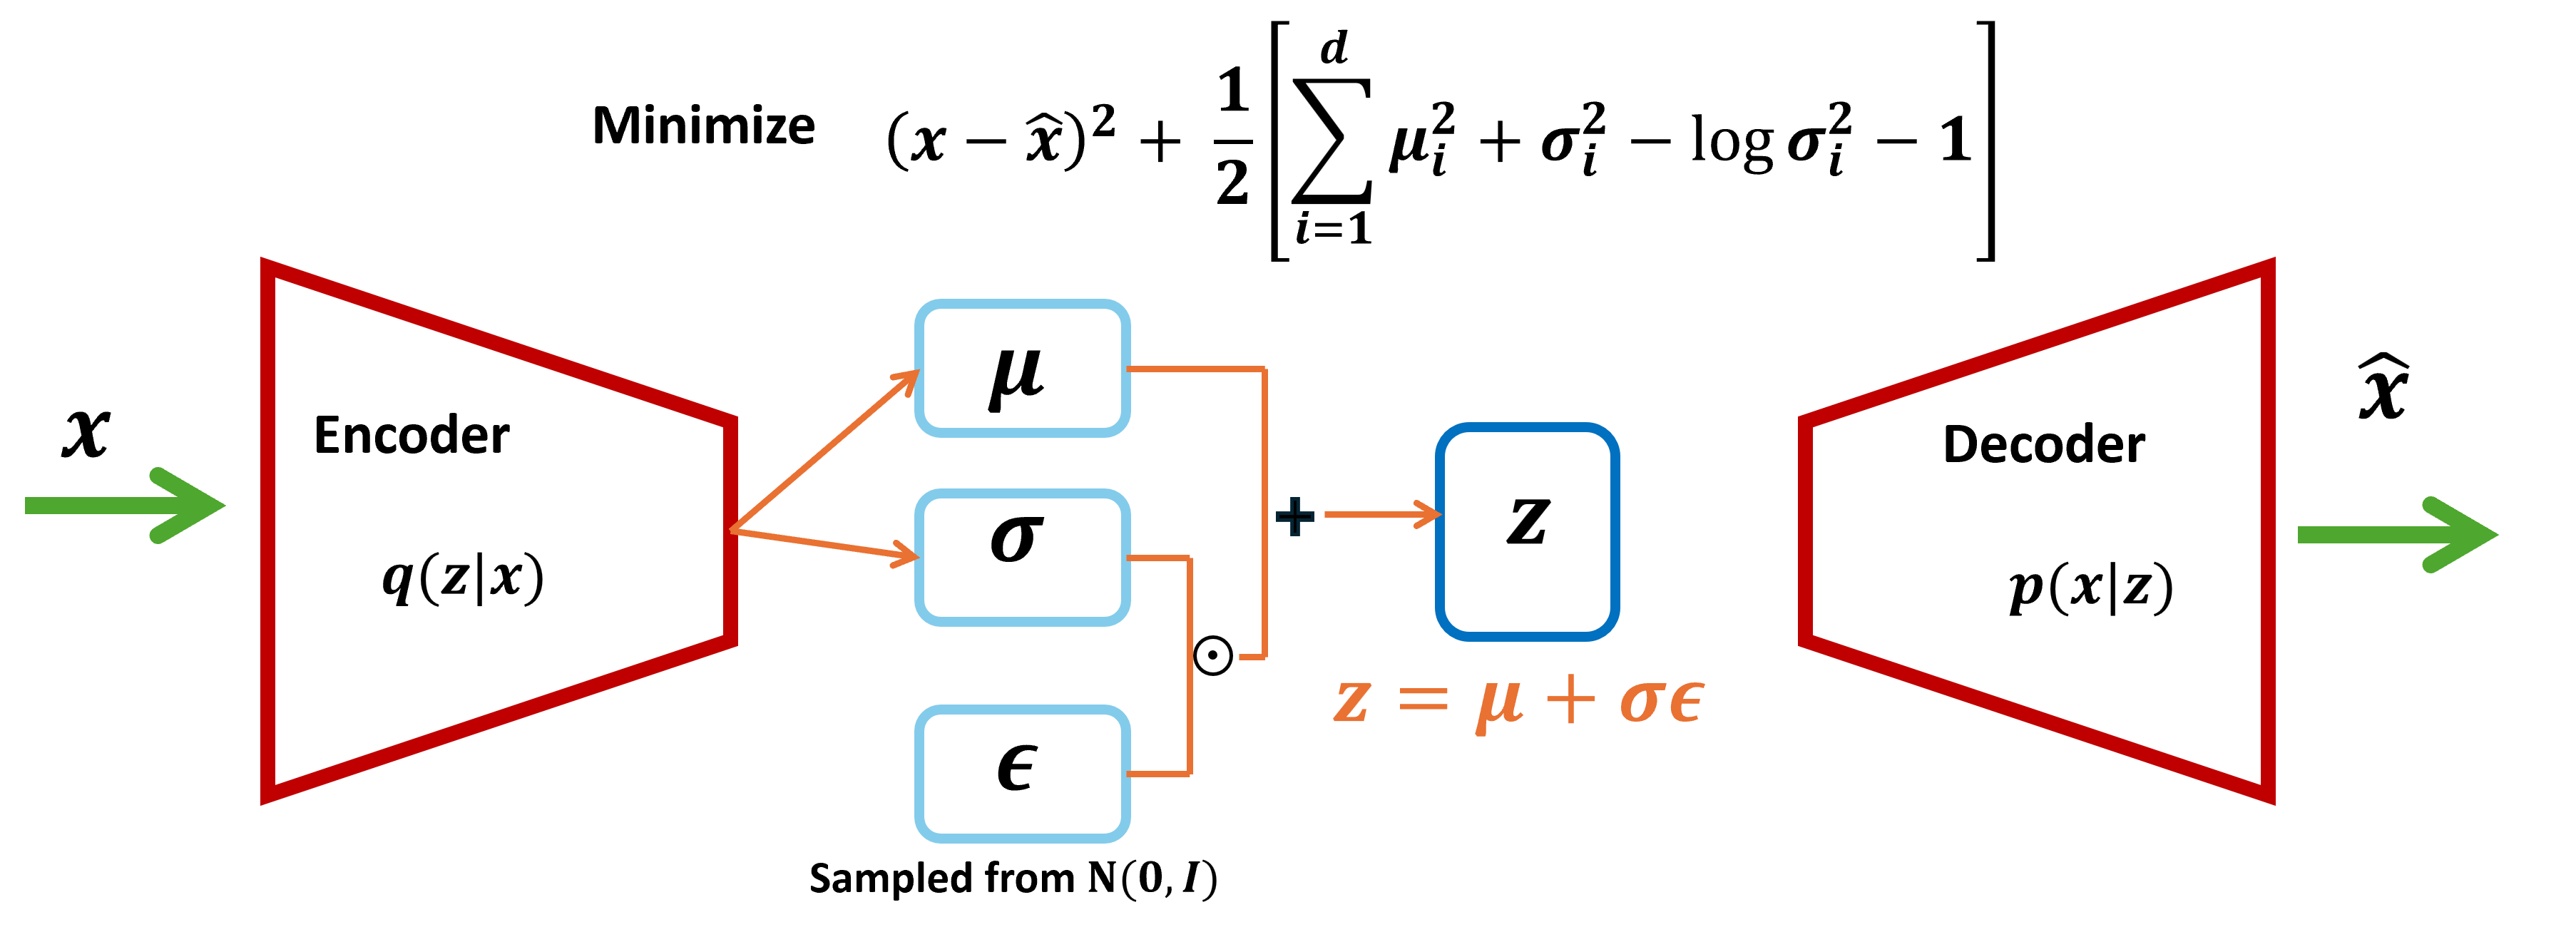

Standard `model.compile()` in TensorFlow is designed for single-term loss functions, such as reconstruction loss. To implement the composite lost function of VAE (two-terms) we need to define a custom class, so that the model handles the custom loss function. In doing so, we also implement `train_step`, and `test_step` function which are inherited from `keras.model' to impose both loss terms.

In [ ]:
# Manipulating the loss function is not straightforward in keras. Therefore, the best and safest way is to define a
# class and customize the training loop and the loss function

# VAE model class
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property   # this keywork transforms a method into a property, allowing it to be called like a class attribute
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker];


# train_step, and test_step functions are not directly called by user
# rather,  the Keras framework automatically calls them for each batch during the training epochs and the test_step method
# for each batch in the validation data (if provided) at the end of each epoch
    def train_step(self, data): # the function name should not change
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z, training=True)
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            loss = recon_loss + kl_loss
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):  # the function name should not change
        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z, training=False)
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        loss = recon_loss + kl_loss
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics};
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

The VAE is implemented as follows with a simple architecture.

In [ ]:
# Build a VAE. Keep the architecture simple for easier debugging. The model can be make complex after a full evaluation of outcomes
INPUT_DIM = daily_hourly_standardized.shape[1]; # 24*len(exog_columns)
LATENT_DIM = 16 # Dimension of the latent space
EPOCH_NUM = 5;
BATCH_SIZE = 32;
H1, H2 = 128, 64;

# Split into training and validation
train_size = int(len(daily_hourly_standardized) * 0.7);
train_data = daily_hourly_standardized[:train_size];
val_data = daily_hourly_standardized[train_size:];

# Build encoder
inputs = Input(shape=(INPUT_DIM,), name="x");
h1 = Dense(H1, activation="relu")(inputs);
h2 = Dense(H2, activation="relu")(h1);
z_mean = Dense(LATENT_DIM, name="z_mean")(h2); # name this layers to reference in the sampling layer
z_log_var = Dense(LATENT_DIM, name="z_log_var")(h2)# name this layers to reference in the sampling layer
z = Sampling()([z_mean, z_log_var]); # sampling step with reparameterization trick
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder"); # encoder definition is complete

# Build decoder
latent_inputs = Input(shape=(LATENT_DIM,), name="z_input");
d1 = Dense(H2, activation="relu")(latent_inputs);
d2 = Dense(H1, activation="relu")(d1);
outputs = Dense(INPUT_DIM, activation=None, name="x_hat")(d2);
decoder = Model(latent_inputs, outputs, name="decoder");

# Create a VAE instance
vae = VAE(encoder, decoder); # we defined the loss, and training steps inside the class, so the keras is forced to used the custom loss function.
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-3));

# Early Stopping (ES) used during model training to stop the process early if validation loss is low enough
ES = callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True); # patience allows the model to ran at least some iterations before making a deicions
fitted = vae.fit(train_data, validation_data=(val_data,), epochs=EPOCH_NUM, batch_size=BATCH_SIZE, callbacks=[ES], verbose=1);

Once the VAE is trained and the parameters of the Gaussian distributions are learned, we generate a set of synthetic sample. Notice that these samples are not necessarily extreme.

In [ ]:
# Generate 100 standardized scenarios (full 72 columns) and compare the load with actual days
z_samples = tf.random.normal(shape=(100, LATENT_DIM));
gen_samples_standard = decoder.predict(z_samples);
gen_samples = gen_samples_standard*cols_std+cols_mean;

# keep the load part only
gen_load = gen_samples[:,::len(selected_columns)];
gen_loadT = gen_load.T;

actual_load = daily_hourly_standardized*cols_std+cols_mean;
actual_load = actual_load[:, ::len(selected_columns)];
actual_loadT = actual_load.T;

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4),
                       gridspec_kw={'width_ratios': [10, 10],'height_ratios': [5],
                       'wspace': 0.1,'hspace': 0.1});
ax[0].plot(actual_loadT[:,:5]);
ax[1].plot(gen_loadT[:,:5]);
ax[0].set_title('Load profile of actual days')
ax[1].set_title('Load profile of generated days')

<br>
<br>
<br>

# **<font color='blue'>7. Conditional Variational Autoencoder </font>** <a name="CVAE"></a>

CVAE extends VAE by incorporating auxiliary information to control the sampling process, which is especially useful when we want to generate data that depends on certain labels or attributes. The conditioning information is usually added with the encoder and decoder, allowing the CVAE to learn the variations within each category instead of encoding conditional information into the latent space.

In [ ]:
# Adjust the VAE class defined before
class CVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder;
        self.decoder = decoder;
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss");
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss");
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss");

    @property   # this keywork transforms a method into a property, allowing it to be called like a class attribute
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker];

    def train_step(self, data): # the function name should not change
        dat, Con = data[0];  # (ADDED) dat: data itself, Con: condition labels
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([dat,Con], training=True); # (ADJUSTED)
            reconstruction = self.decoder([z,Con], training=True); # (ADJUSTED)

            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(dat - reconstruction), axis=1));
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1));
            loss = recon_loss + kl_loss;
        grads = tape.gradient(loss, self.trainable_variables);
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables));
        self.total_loss_tracker.update_state(loss);
        self.recon_loss_tracker.update_state(recon_loss);
        self.kl_loss_tracker.update_state(kl_loss);
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):  # the function name should not change
        dat, Con = data[0];  # (ADDED) dat: data itself, Con: condition labels
        z_mean, z_log_var, z = self.encoder([dat, Con], training=False)
        reconstruction = self.decoder([z, Con], training=False);
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(dat - reconstruction), axis=1));
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1));
        loss = recon_loss + kl_loss;
        self.total_loss_tracker.update_state(loss);
        self.recon_loss_tracker.update_state(recon_loss);
        self.kl_loss_tracker.update_state(kl_loss);
        return {m.name: m.result() for m in self.metrics};

Classify each day into one of the $N$ categories in which the values indicate the potential for renewable generation (level 0 lower potential, level $N-1$ highest).

In [ ]:
irradiance_mean = daily_hourly_standardized[:,2::].mean(axis=1);  # calculate daily average of irradiance (standardized)
wind_speed_mean = daily_hourly_standardized[:,3::].mean(axis=1)   # daily average of wind speed (standardized)
renewable_potential = irradiance_mean + wind_speed_mean;          # combined daily average of irradiance and wind speed (standardized)

discretizer = KBinsDiscretizer(n_bins = 10, encode='ordinal', strategy='kmeans'); # level N-1 is the highest total potential
day_labels = discretizer.fit_transform(renewable_potential.reshape(-1, 1)).astype(int).flatten();
print(np.unique(day_labels, return_counts=True));

Next, we convert the labels to one-hot encoding to provide a unambiguous conditioning information for the CVAE.

In [ ]:
def one_hot(y, n_classes):
    '''
    return one-hot matrix for y

    y: numpy array of shape (n_samples,)
    n_classes: int
    return: numpy array of shape (n_samples, n_classes)


    eg., y=[1, 0,1, 2], and n_classes=3, then return
    [[0, 1, 0],
     [1, 0, 0],
     [0, 1, 0],
     [0, 0, 1]]
    '''
    one_hot = np.zeros((y.shape[0], n_classes), dtype="float32");
    one_hot[np.arange(y.shape[0]), y] = 1;
    return one_hot;

In [ ]:
# prepare the data
y_cond = one_hot(day_labels, n_classes=day_labels.max()+1);  # alternatively: tf.keras.utils.to_categorical(vRE_status, num_classes=vRE_status.max()+1)
train_size = int(len(daily_hourly_standardized) * 0.8);
train_data = daily_hourly_standardized[:train_size];
val_data = daily_hourly_standardized[train_size:];
train_cond = y_cond[:train_size];
val_cond = y_cond[train_size:];

Build a simple CVAE and train the model.

In [ ]:
# Build a VAE. Keep the architecture simple for easier debugging. The model can be make complex after a full evaluation of outcomes
INPUT_DIM = daily_hourly_standardized.shape[1]; # 24*len(exog_columns)
LATENT_DIM = 8 # Dimension of the latent space
EPOCH_NUM = 20;
BATCH_SIZE = 32;
H1, H2 = 128, 64;
CON_DIM = day_labels.max()+1;  # the size of the condition (number of bins to categorize days)

# Build encoder
inputs = Input(shape=(INPUT_DIM,), name="x");
con_input = Input(shape=(CON_DIM,), name="con_input"); # (ADDED)
enc_in = Concatenate()([inputs, con_input]); #(ADDED)

h1 = Dense(H1, activation="relu")(con_input); #(ADJUSTED)
h2 = Dense(H2, activation="relu")(h1);
z_mean = Dense(LATENT_DIM, name="z_mean")(h2);
z_log_var = Dense(LATENT_DIM, name="z_log_var")(h2);
z = Sampling()([z_mean, z_log_var]);
encoder = Model([inputs, con_input], [z_mean, z_log_var, z], name="encoder"); # (ADJUSTED)

# Build decoder
latent_inputs = Input(shape=(LATENT_DIM,), name="z_input");
con_dec = Input(shape=(CON_DIM,), name="con_dec"); #(ADDED)
dec_in = Concatenate()([latent_inputs, con_dec]); #(ADDED)

d1 = Dense(H2, activation="relu")(dec_in);  #(ADJUSTED)
d2 = Dense(H1, activation="relu")(d1);
outputs = Dense(INPUT_DIM, activation=None, name="x_hat")(d2);
decoder = Model([latent_inputs, con_dec], outputs, name="decoder");

# Create a VAE instance
cvae = CVAE(encoder, decoder); # we defined the loss, and training steps inside the class, so the keras is forced to used the custom loss function.
cvae.compile(optimizer=tf.keras.optimizers.Adam(1e-3));

# Early Stopping (ES) used during model training to stop the process early if validation loss is low enough
ES = callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True); # patience allows the model to ran at least some iterations before making a deicions
fitted = cvae.fit(([train_data, train_cond]), validation_data=([val_data, val_cond],), epochs=EPOCH_NUM, batch_size=BATCH_SIZE, callbacks=[ES], verbose=0);

print("\t Training completed!\n\t Plot the loss");

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3),
                       gridspec_kw={'width_ratios': [10],'height_ratios': [5],
                       'wspace': 0.1,'hspace': 0.1});

# Plot training and validation loss
ax.plot(fitted.history['loss'], label='Training Loss')
ax.plot(fitted.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Autoencoder Training and Validation Loss');
ax.legend(loc='upper center',ncol=1, bbox_to_anchor=(0.5, 1), prop={'size': 8});

**Some observations** that can expalin the less-than-desirable performance for the VAE/CVAE and generally for other neural network models:

- Very limited training and validation data
- No hyper-parameter tuning:
  - More complex model more layers or neurons in each layer, can help
  - Adjusting the learning rate can help
- Crucially, the distribution of training and validation datasets is not entirely the same. We already know that the validation set is the last 20\% of the data, thus the end of Fall and early Winter days, which we already know are different than Summer and Spring days (both in terms of load, and renewable profiles).
- The loss function does not adjust the weight of the KL terms. Reducing its impact by a parameter can help.


<br>
<br>

**The trained CVAE** allows us to condition on the worst renewable potential (as defined above = low value of combined average irradiance and wind speed).



In [ ]:
num_samples = 100;
y_cond = np.zeros((num_samples, CON_DIM)); # 100 samples, 4 categoris
y_cond[:, 0] = 1;  # all to be extreme days as defined by low renewable output potential
z = np.random.normal(size=(num_samples, 8));
samples = cvae.decoder.predict([z, y_cond]);
generated = samples*cols_std+cols_mean;

# Visualize the irradiance or wind speed profiles
gen_profile = generated[:,2::len(selected_columns)];
gen_profileT = gen_profile.T;

actuals = daily_hourly_standardized*cols_std+cols_mean;
actual_profile = actuals[:, 2::len(selected_columns)];
actual_profileT = actual_profile.T;

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4),
                       gridspec_kw={'width_ratios': [10, 10, 10],'height_ratios': [5],
                       'wspace': 0.5,'hspace': 0.1});
actual_profile_levelL = actual_profileT[:,day_labels==day_labels.min()];
actual_profile_levelH = actual_profileT[:,day_labels==day_labels.max()];
ax[0].plot(actual_profile_levelH[:,:5]);
ax[1].plot(actual_profile_levelL[:,:5]);
ax[2].plot(gen_profileT[:,:5]);
ax[0].set_title('Actual profiles with high renewable potential', fontsize=9);
ax[1].set_title('Actual profiles with low renewable potential', fontsize=9);
ax[2].set_title('Generated profiles with low renewable potential', fontsize=9);

In [ ]:
# data.head(20)

Besides visual inspection, there are different methods to validate the generated profiles, including marginal distribution comparison, autocorrelation analysis, Kolmogorov-Smirnov (KS) test, among others. Here, we plot ACF/PACF plots to analyze and compare the autocorrelation in both real and synthetic scenarios.

In [ ]:
# ACF/PACF plots
actual_wind_levelL_mean = actual_profile_levelL.mean(axis=0);
gen_wind_mean = gen_profile.mean(axis=1);
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf; # for ACF and PACF plots

fig1 = plot_acf(actual_profile_levelL.T.reshape(-1,), lags=48);
fig2 = plot_pacf(gen_profile.reshape(-1), lags=48);
fig1.set_size_inches(6,2);
fig2.set_size_inches(6,2);

<br>
<br>
<br>

# **<font color='blue'>8. Case Study Questions </font>** <a name="questions"></a>

The case study questions cover both the extreme days detection and the CVAE.
## Extreme Day Detection

Download the `ERCOT_hourly_load_data_2002_2021.csv` from the [GitHub repository for the case studies](https://github.com/RahmanKhorramfar91/UAI_AI_Energy_Case_Studies). The file contains the historical bulk load for the regions in Texas served by the Electric Reliability Council of Texas (ERCOT) between 2002 and 2021. The original data is obtained from [ERCOT's website](https://www.ercot.com/gridinfo/load/load_hist/index.html) and curated for this case study.

We are going to work with the data for the year 2021, as the region experienced a severe power outage due to a series of wind storms impacting the region from February 11 to 20. Therefore, we can verifiably know that at least some of the days during this period are extreme.

**<font color='red'> Questions </font>**
1. Apply DBSCAN, GMM, and train a VA to identify extreme days for the year 2021 with your choice of parameters. Use BIC and AIC methods to determine the number of clusters in GMM. How do their outcomes differ? Have any of the extreme days caused by winter storms been identified?

2. Similar to forecasting, the performance of outlier detection algorithms can be evaluated by their downstream task. Can you think of a way to train these algorithms iteratively based on the feedback from the user (e.g., utility vs generation company vs policy makers)? Explain your answer and outline your framework without being too rigorous.

<br>

 ## Load Generation
Let's consider the `load_time_series_data_ISONE_2000-2023' dataset.

**<font color='red'> Questions </font>**

1. Follow these steps to generate 100 extreme scenarios:

 -  Consider columns`'gross_load_MW', 'temperature_C'` and read each file from 2000 to 2023, reshape the data such that each row represents a day and columns represent hour of the day, standardize each year's data, and concatenate them all to form a single data set with about 365*24 columns and 24 rows. The function `concat` can be used from `pandas` package.
 - Train a CVAE model to condition on the 5 levels of total daily load. The function `KBinsDiscretizer' from`sklearn` package can help to discretize the space.
 - Generate 100 extreme days with a total daily load level of 5 (the highest level)

 Now, visually inspect the generated samples, tune parameters, and comment of the realism of the synthetic samples.

2. What ways do you think can help generate more realistic load and meteorological data? How do you think the impact of climate change, policy shifts, and socio-economic factors can be incorporated as part of the generative model?
<br>
<br>
<br>

# **<font color='blue'>9. References and Further Reading </font>** <a name="references"></a>

**Main references used in the tutorial portion of this case study:**

- Foster, D. (2022). Generative deep learning. " O'Reilly Media, Inc.". ([link to the book](https://www.oreilly.com/library/view/generative-deep-learning/9781098134174/), [website](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition?tab=readme-ov-file))
- Prince, S. J. (2023). Understanding deep learning. MIT Press. ([link to the book](https://www.amazon.com/Understanding-Deep-Learning-Simon-Prince/dp/0262048647), [website](https://udlbook.github.io/udlbook/))
- Kingma, D. P., & Welling, M. (2019). An introduction to variational autoencoders. Foundations and Trends® in Machine Learning, 12(4), 307-392. [link](https://www.nowpublishers.com/article/Details/MAL-056)
- Aggarwal, C. C. (2016). An introduction to outlier analysis. In Outlier analysis (pp. 1-34). Cham: Springer International Publishing. [link](https://link.springer.com/chapter/10.1007/978-3-319-47578-3_1)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

